# 🧠 Project Idea 1 – Gene → Protein → Small Molecule Association

Theme:

“Find genes coding for drug-metabolizing enzymes (like CYP450s), analyze their sequences, and visualize related molecules that act as their substrates.”

- 🔹 Step 1: Fetch Sequences from NCBI. Hint:
Use Biopython’s Entrez to search and fetch a few gene/protein sequences.

- 🔹 Step 2: Sequence Summary and Statistics. Hint: Create a simple table summarizing sequence properties (Ids, GC content and length).

- 🔹Step 3: Visualize Sequence Data. Create a Histogram of cds length and  GC_content

- 🔹 Step 4: Integrate Chemical Data with RDKit.

substrates = {
    "CYP1A2": "Cn1cnc2c1c(=O)n(C)c(=O)n2C",   # caffeine
    "CYP2D6": "CC(C)NCC(O)c1ccc2ccccc2c1",  # propranolol
    "CYP3A4": "CC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C",  # testosterone
}

Calculate Mol Wt and TPSA for all the SMILES and summarise in a df.


- 🔹 Step 5: Combine Gene + Molecule Info (Scatter plot GC_content vs TPSA, colored by gene)

- 🔹 Step 6: Multi-Molecule Visualization

In [4]:
# !pip install Bio
# !pip install rdkit

In [21]:
from Bio import Entrez, SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from collections import OrderedDict
import io, time

In [26]:
Entrez.email = "princek.iitk@gmail.com"  # keep a real contact

Entrez.tool  = "CYP_fetch_demo"


term = (
    '"Homo sapiens"[Organism] '
    'AND srcdb_refseq_known[PROP] '    # curated RefSeq only (e.g., NM_, NR_)
    'AND biomol_mrna[PROP] '
    'AND (CYP[Gene Name] OR "cytochrome P450"[Title] OR CYP[Title])'
)

h = Entrez.esearch(db="nuccore", term=term, retmax=500)
res = Entrez.read(h); h.close()
ids = res["IdList"]
print("IDs:", len(ids))

if ids:
    with Entrez.efetch(db="nuccore", id=",".join(ids),
                       rettype="fasta_cds_na", retmode="text") as fh:
        fasta_text = fh.read()
    records = list(SeqIO.parse(io.StringIO(fasta_text), "fasta"))
    print("Fetched curated CDS:", len(records))
else:
    print("No hits.")


IDs: 149
Fetched curated CDS: 149


In [31]:
data = []
for seq in records:
    if "|NM_" not in seq.id:
      continue
    data.append({
        "ID": seq.id,
        "Seq": str(seq.seq),
        "Length": len(seq.seq),
        "GC_Content (%)": round(100 * (seq.seq.count("G") + seq.seq.count("C")) /
                            len(seq.seq), 2),
    })

df_genes = pd.DataFrame(data)
df_genes

,ID,Seq,Length,GC_Content (%)
0,lcl|NM_001348386.3_cds_NP_001335315.1_1,ATGGGGCTAGAAGCACTGGTGCCCCTGGCCATGATAGTGGCCATCT...,1551,64.22
1,lcl|NM_000498.3_cds_NP_000489.3_1,ATGGCACTCAGGGCAAAGGCAGAGGTGTGCGTGGCAGCGCCCTGGC...,1512,59.59
2,lcl|NM_000764.3_cds_NP_000755.2_1,ATGCTGGCCTCAGGGCTGCTTCTGGTGGCCTTGCTGGCCTGCCTGA...,1485,56.43
3,lcl|NM_030589.3_cds_NP_085079.2_1,ATGCTGGCCTCAGGGCTGCTTCTGGTGGCCTTGCTGGCCTGCCTGA...,1332,55.78
4,lcl|NM_000104.4_cds_NP_000095.2_1,ATGGGCACCAGCCTCAGCCCGAACGACCCTTGGCCGCTAAACCCGC...,1632,61.21
...,...,...,...,...
144,lcl|NM_001347248.1_cds_NP_001334177.1_1,ATGGTTTTGGAAATGCTGAACCCGATACATTATAACATCACCAGCA...,1512,45.04
145,lcl|NM_001437457.1_cds_NP_001424386.1_1,ATGAGTGTCTCTGTCCTGAGCCCCAGCAGACGCCTGGGTGGTGTCT...,1266,55.61
146,lcl|NM_001308102.2_cds_NP_001295031.1_1,ATGAGTGTCTCTGTCCTGAGCCCCAGCAGACGCCTGGGTGGTGTCT...,1074,55.68
147,lcl|NM_001010969.4_cds_NP_001010969.2_1,ATGAGTGTCTCTGTCCTGAGCCCCAGCAGACGCCTGGGTGGTGTCT...,1560,55.71


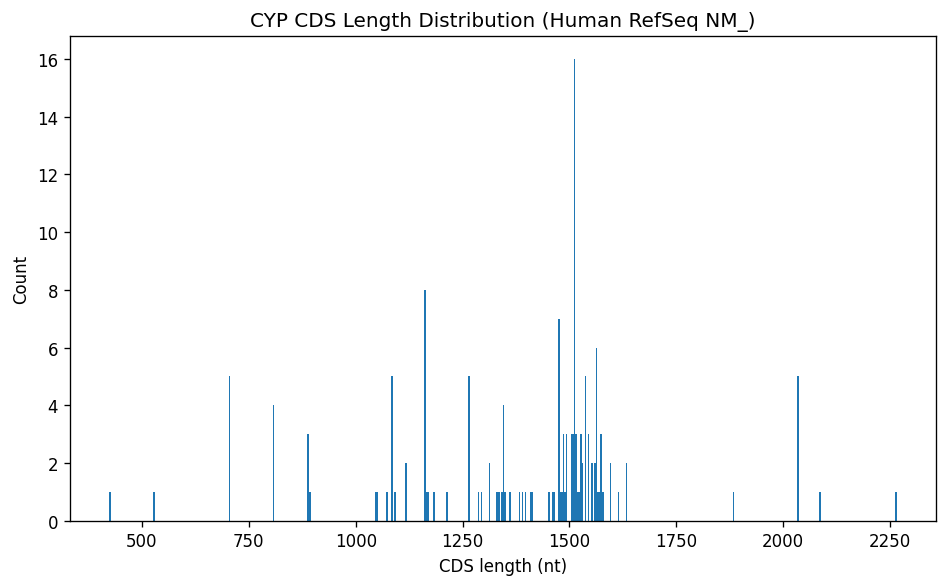

In [46]:
# Plot 1: Length distribution
plt.figure(figsize=(8, 5), dpi=120)
plt.hist(df_genes["Length"].values, bins=500)
plt.xlabel("CDS length (nt)")
plt.ylabel("Count")
plt.title("CYP CDS Length Distribution (Human RefSeq NM_)")
plt.tight_layout()
plt.show()

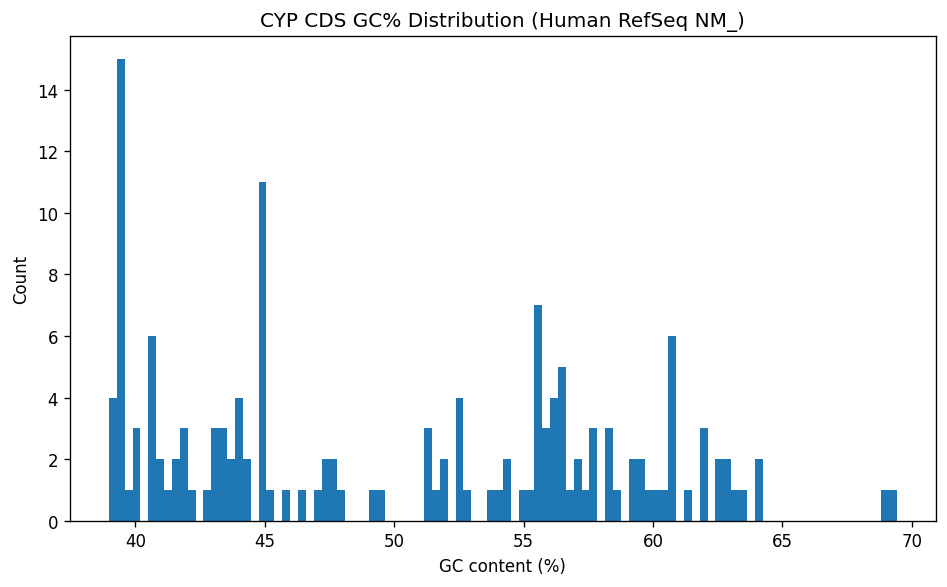

In [44]:
# Plot 2: GC% distribution
plt.figure(figsize=(8, 5), dpi=120)
plt.hist(df_genes["GC_Content (%)"].values, bins=100)
plt.xlabel("GC content (%)")
plt.ylabel("Count")
plt.title("CYP CDS GC% Distribution (Human RefSeq NM_)")
plt.tight_layout()
plt.show()

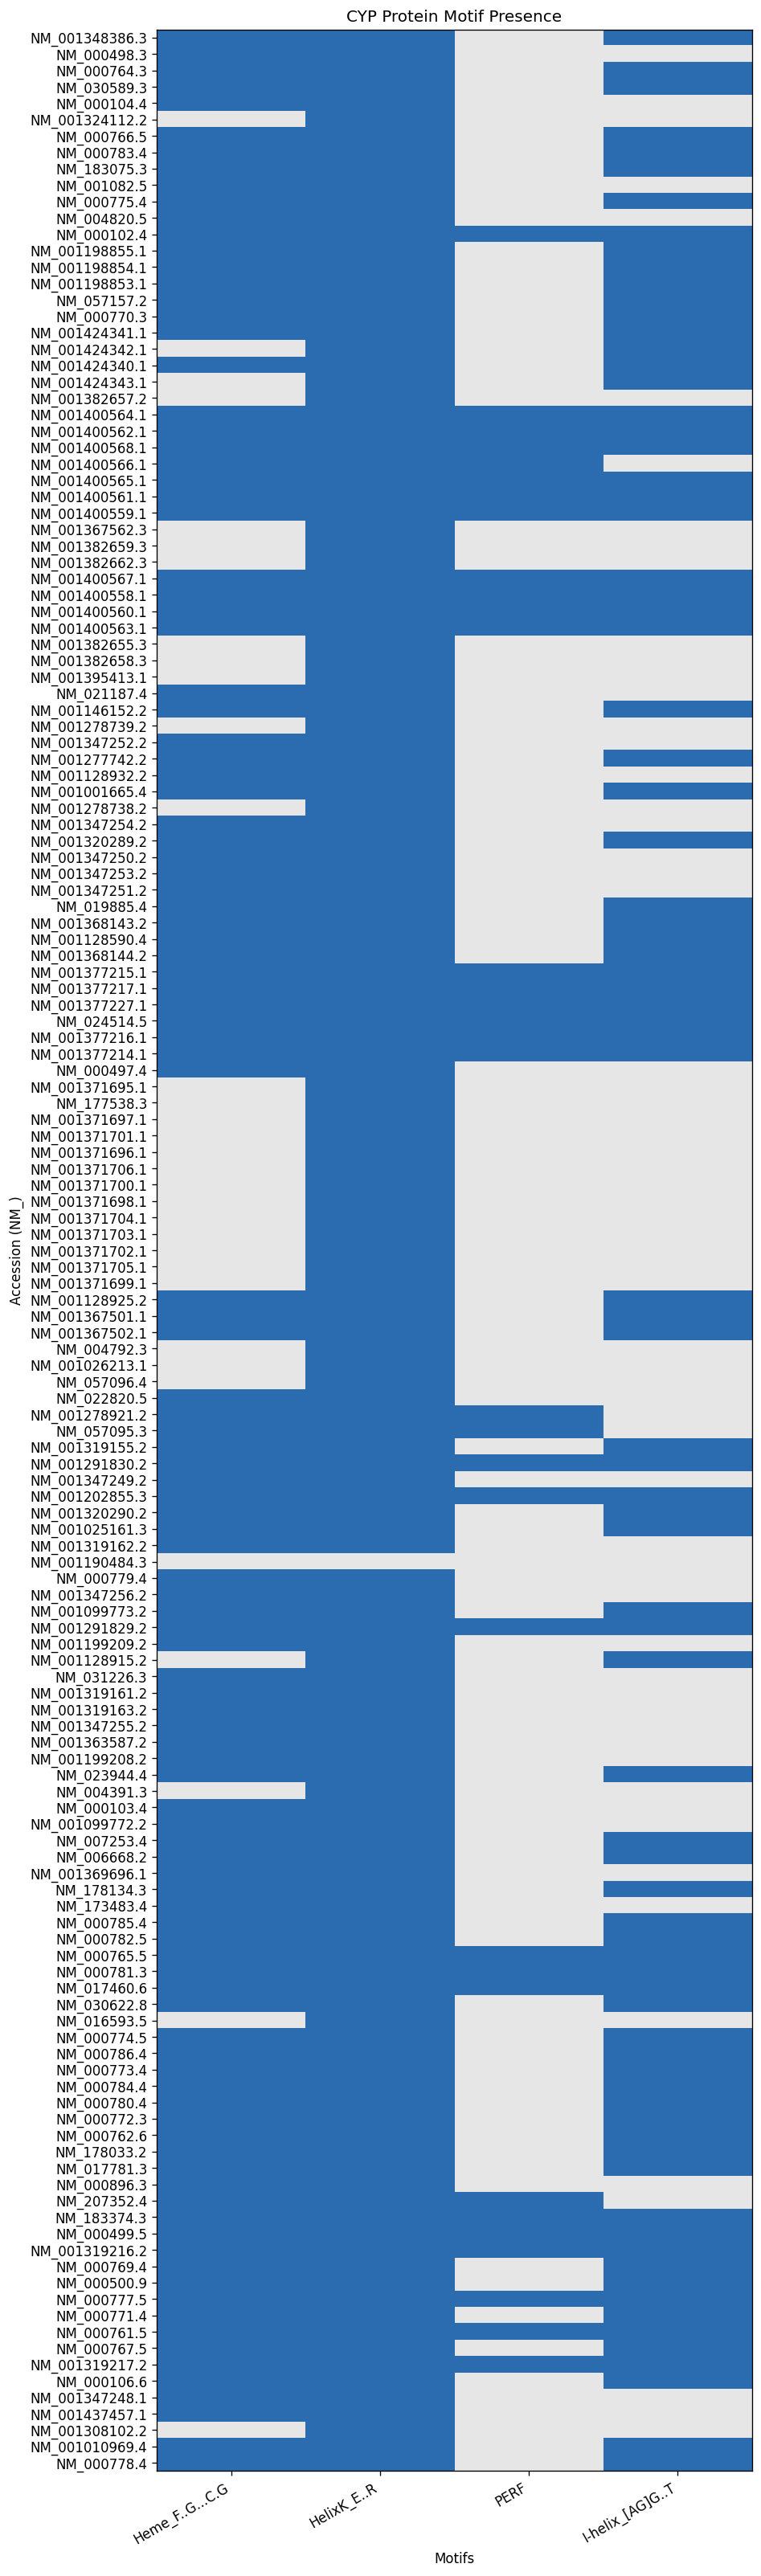

Saved: cyp_motif_presence.csv


In [49]:
# Motif presence heatmap on translated proteins

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Try Biopython for translation; otherwise use a minimal fallback table
try:
    from Bio.Seq import Seq
    BIOPY_AVAILABLE = True
except Exception:
    BIOPY_AVAILABLE = False

df = df_genes.copy()

def _coerce_seq(x):
    s = str(x).replace(" ", "").upper()
    s = re.sub(r"[^ACGTN]", "", s)
    return s

df["Seq"] = df["Seq"].map(_coerce_seq)

def translate_cds(seq):
    L = len(seq) - (len(seq) % 3)
    if L <= 0:
        return ""
    if BIOPY_AVAILABLE:
        try:
            return str(Seq(seq[:L]).translate(to_stop=False))
        except Exception:
            pass
    # Minimal fallback translation
    table = {
        "TTT":"F","TTC":"F","TTA":"L","TTG":"L",
        "TCT":"S","TCC":"S","TCA":"S","TCG":"S",
        "TAT":"Y","TAC":"Y","TAA":"*","TAG":"*",
        "TGT":"C","TGC":"C","TGA":"*","TGG":"W",
        "CTT":"L","CTC":"L","CTA":"L","CTG":"L",
        "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
        "CAT":"H","CAC":"H","CAA":"Q","CAG":"Q",
        "CGT":"R","CGC":"R","CGA":"R","CGG":"R",
        "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
        "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
        "AAT":"N","AAC":"N","AAA":"K","AAG":"K",
        "AGT":"S","AGC":"S","AGA":"R","AGG":"R",
        "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
        "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
        "GAT":"D","GAC":"D","GAA":"E","GAG":"E",
        "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    }
    prot = []
    for i in range(0, L, 3):
        prot.append(table.get(seq[i:i+3], "X"))
    return "".join(prot)

# Translate to protein
df["Protein"] = df["Seq"].map(translate_cds)

# Extract concise NM_ accession to label rows
def short_id(s):
    m = re.search(r"(NM_\d+\.\d+)", str(s))
    return m.group(1) if m else str(s).split("|")[-1]

df["Accession"] = df["ID"].map(short_id)

# Define canonical CYP motifs as regex
motifs = {
    "Heme_F..G...C.G": re.compile(r"F..G...C.G"),  # heme-binding motif
    "HelixK_E..R": re.compile(r"E..R"),            # Helix K
    "PERF": re.compile(r"PERF"),                   # PERF region
    "I-helix_[AG]G..T": re.compile(r"[AG]G..T"),   # I-helix oxygen-binding region (approx)
}

# Build presence matrix
rows = []
for _, r in df.iterrows():
    prot = r["Protein"]
    row = {"Accession": r["Accession"]}
    for name, rx in motifs.items():
        row[name] = 1 if (prot and rx.search(prot)) else 0
    rows.append(row)

motif_df = pd.DataFrame(rows).set_index("Accession")

# Binary colormap: 0 -> light gray, 1 -> dark blue
cmap = ListedColormap(["#e6e6e6", "#2b6cb0"])
norm = BoundaryNorm([ -0.5, 0.5, 1.5 ], ncolors=cmap.N)  # bins for 0 and 1

# Heatmap
mat = motif_df.values.astype(float)
plt.figure(figsize=(8, max(6, 0.18 * mat.shape[0])), dpi=120)
plt.imshow(mat, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.yticks(np.arange(mat.shape[0]), motif_df.index)
plt.xticks(np.arange(mat.shape[1]), motif_df.columns, rotation=30, ha="right")
plt.xlabel("Motifs")
plt.ylabel("Accession (NM_)")
plt.title("CYP Protein Motif Presence")
plt.tight_layout()
plt.show()

# Optional: save matrix
motif_df.to_csv("cyp_motif_presence.csv")
print("Saved: cyp_motif_presence.csv")

In [52]:
substrates = {
    "CYP1A2": "Cn1cnc2c1c(=O)n(C)c(=O)n2C",   # caffeine
    "CYP2D6": "CC(C)NCC(O)c1ccc2ccccc2c1",  # propranolol
    "CYP3A4": "CC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C",  # testosterone
}

mol_data = []
for gene, smile in substrates.items():
    mol = Chem.MolFromSmiles(smile)
    mol_data.append({
        "Gene": gene,
        "SMILES": smile,
        "MolWt": Descriptors.MolWt(mol),
        "TPSA": Chem.rdMolDescriptors.CalcTPSA(mol),
    })

df_mols = pd.DataFrame(mol_data)
df_mols

,Gene,SMILES,MolWt,TPSA
0,CYP1A2,Cn1cnc2c1c(=O)n(C)c(=O)n2C,194.194,61.82
1,CYP2D6,CC(C)NCC(O)c1ccc2ccccc2c1,229.323,32.26
2,CYP3A4,CC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,286.459,17.07


In [50]:
import re
from io import StringIO
from Bio import Entrez, SeqIO
import pandas as pd

Entrez.email = "princek.iitk@gmail.com"
Entrez.tool  = "CYP_fetch_demo"

# 1) Pull NM_* accessions out of your ID column
def extract_nm(s: str) -> str | None:
    m = re.search(r'(NM_\d+\.\d+)', s)
    return m.group(1) if m else None

df_genes = df_genes.copy()
df_genes["NM_acc"] = df_genes["ID"].apply(extract_nm)

nm_unique = sorted(x for x in df_genes["NM_acc"].dropna().unique())

# 2) Build NM -> gene symbol map via GenBank parsing
nm_to_gene = {}
batch_size = 100
for i in range(0, len(nm_unique), batch_size):
    chunk = nm_unique[i:i+batch_size]
    with Entrez.efetch(db="nuccore", id=",".join(chunk), rettype="gb", retmode="text") as h:
        gb_text = h.read()
    for rec in SeqIO.parse(StringIO(gb_text), "gb"):
        nm = rec.id  # should match NM_.... versioned accession
        gene_sym = None

        # Prefer Gene features if present
        for feat in rec.features:
            if feat.type in ("CDS", "gene"):
                # common locations for the symbol
                if "gene" in feat.qualifiers:
                    gene_sym = feat.qualifiers["gene"][0]
                    break
                if "gene_synonym" in feat.qualifiers:
                    gene_sym = feat.qualifiers["gene_synonym"][0].split(";")[0]
                    break

        # Fallbacks if needed
        if not gene_sym and "gene" in rec.annotations:
            gene_sym = rec.annotations["gene"]

        if not gene_sym and rec.description:
            # last-ditch heuristic, often description starts with symbol
            m = re.match(r'^([A-Z0-9]+)\b', rec.description)
            if m:
                gene_sym = m.group(1)

        if gene_sym:
            nm_to_gene[nm] = gene_sym

# 3) Attach gene symbol
df_genes["Gene"] = df_genes["NM_acc"].map(nm_to_gene)

In [56]:
# 4) Merge with your small substrate table (left join keeps all transcripts)
df_merged = df_genes.merge(df_mols, on="Gene", how="left")
df_merged = df_merged[df_merged['Gene'].isin(set(df_mols['Gene'].dropna()))]
# Inspect
df_merged[["Gene","NM_acc","ID","Length","GC_Content (%)","SMILES","MolWt","TPSA"]].head(20)

,Gene,NM_acc,ID,Length,GC_Content (%),SMILES,MolWt,TPSA
89,CYP3A4,NM_001202855.3,lcl|NM_001202855.3_cds_NP_001189784.1_1,1509,43.61,CC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,286.459,17.07
91,CYP2D6,NM_001025161.3,lcl|NM_001025161.3_cds_NP_001020332.2_1,1341,63.46,CC(C)NCC(O)c1ccc2ccccc2c1,229.323,32.26
119,CYP3A4,NM_017460.6,lcl|NM_017460.6_cds_NP_059488.2_1,1512,43.65,CC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,286.459,17.07
140,CYP1A2,NM_000761.5,lcl|NM_000761.5_cds_NP_000752.2_1,1551,59.12,Cn1cnc2c1c(=O)n(C)c(=O)n2C,194.194,61.82
143,CYP2D6,NM_000106.6,lcl|NM_000106.6_cds_NP_000097.3_1,1494,63.99,CC(C)NCC(O)c1ccc2ccccc2c1,229.323,32.26


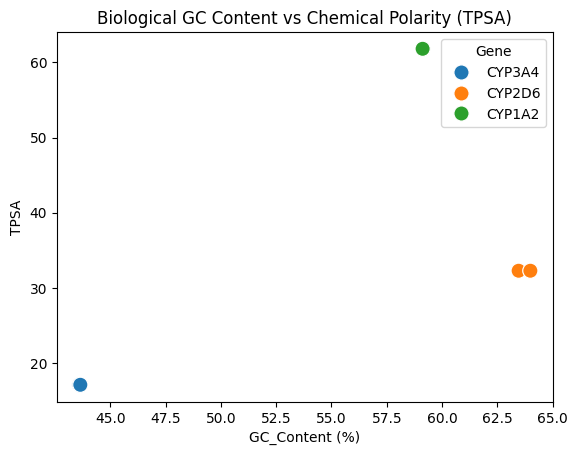

In [58]:
sns.scatterplot(data=df_merged, x="GC_Content (%)", y="TPSA", hue="Gene", s=120)
plt.title("Biological GC Content vs Chemical Polarity (TPSA)")
plt.show()

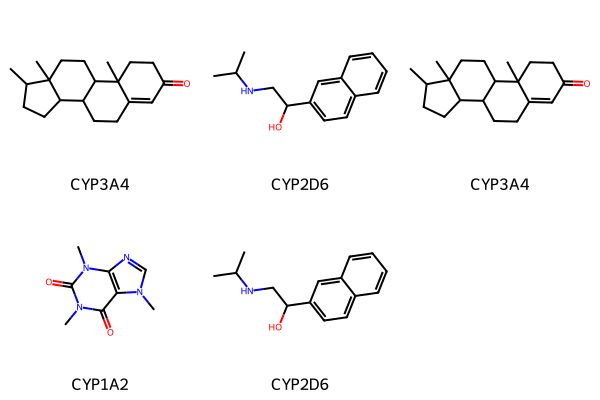

In [61]:
mols = [Chem.MolFromSmiles(s) for s in df_merged["SMILES"].dropna()]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200), legends=list(df_merged["Gene"].dropna()))